In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as datasets
#seems the default size is 1536 x 662 from Kaggle

dataset_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

geoguessr = '/content/gdrive/MyDrive/Colab Notebooks/project/geoguessr'
train_path = geoguessr+'/train_set'
test_path = geoguessr+'/test_set'
valid_path = geoguessr+'/validation_set'

dataset = datasets.ImageFolder(root=geoguessr, transform=dataset_transforms)

train_dataset = torchvision.datasets.ImageFolder(train_path,transform=dataset_transforms)
val_dataset = torchvision.datasets.ImageFolder(valid_path,transform=dataset_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=dataset_transforms)

batch_size = 30;
num_workers = 0;

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

print("Done")

Done


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


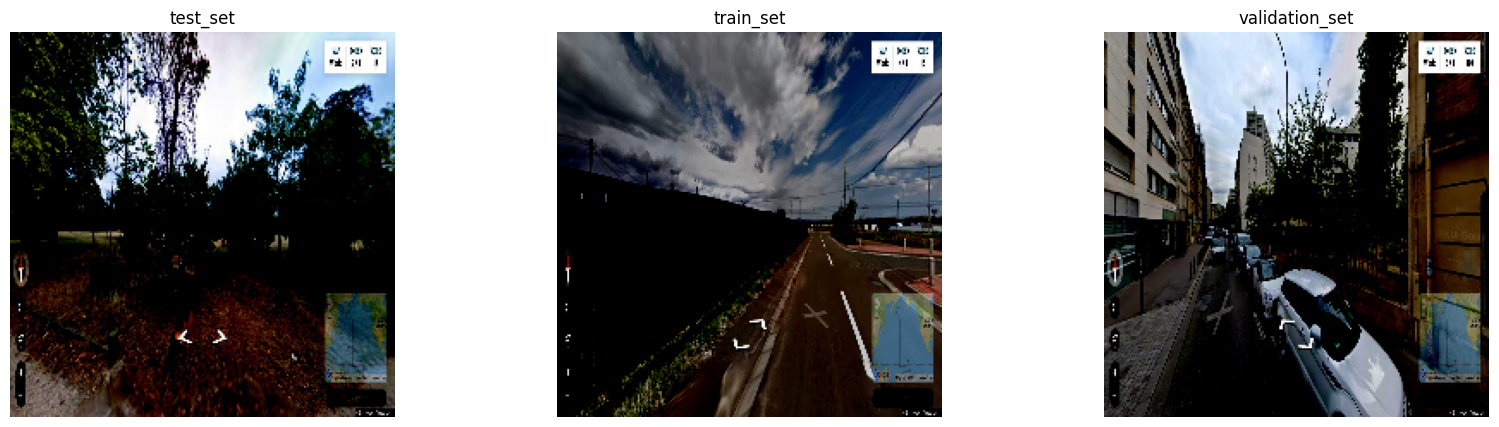

Number of training images: 2941
Number of validation images: 979
Number of testing images: 979


In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
classes = dataset.classes
fig, axis = plt.subplots(1, len(classes), figsize=(20, 5))

for i in range(len(classes)):
    # Get the indices of the images that belong to the current class
    indices = np.where(np.array(dataset.targets) == i)[0]
    # Choose a random index from the indices
    idx = np.random.choice(indices)
    # Get the corresponding image and label
    img, label = dataset[idx]
    # Plot the image and label it with the class name
    axis[i].imshow(img.permute(1, 2, 0))
    axis[i].set_title(classes[label])
    axis[i].axis("off")

plt.show()

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

In [6]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [7]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [8]:
def train(model, train_loader, valid_loader, batch_size=32, learning_rate = 0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss and the optimizer will be Adam
    # These two were selected because:
    # Cross Entropy Loss - Penalizes the model more heavily when it makes larger errors, which is desirable for image classification
    # Adam - Converges faster than other optimization algorithms, which is important for large-scale image classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9) #exponential bad!!
    
    #lr = 0.01 for epoch < 10
    #lr = 0.001 for 10 <= epoch < 20
    #lr = 0.0001 for epoch > 20
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
    ########################################################################
    # Set up some numpy arrays to store the training/test accuracy
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    n = 0 # Iteration number
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            # Forward pass, backward pass, and optimize
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            n += 1
                     
        # Get accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        
        #Step the optimizer
        #scheduler.step() 
            
    epochs = np.arange(1, num_epochs + 1)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_acc, val_acc, epochs
     

In [9]:
def plot_curve(acc, epochs, curve_name):
  plt.plot(epochs, acc)
  plt.title(curve_name + " Curve (Default Parameters)")
  plt.xlabel("Epochs")
  plt.ylabel(curve_name + " Accuracy")
  plt.show()
  return

In [ ]:
!nvidia-smi

Wed Apr  5 22:37:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
class EfficientNetB0(nn.Module):
    def __init__(self):
        super(EfficientNetB0, self).__init__()
        self.name = "EfficientNetB0"
        efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
        self.features = nn.Sequential(*list(efficientnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1280, out_features=5) #top 5 countries
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
#modify to have drop out and one additional convolutional layer
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.name = "CNNModel"
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 5)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
class IntegratedModel(nn.Module):
    def __init__(self, num_classes=5):
        super(IntegratedModel, self).__init__()
        self.name = "integrated_model"
        self.efficientnet = torchvision.models.efficientnet_b0(pretrained=True)

        # for param in self.efficientnet.features.parameters():
        #     param.requires_grad = False #freeze the weights ONLY for efficientnet

        self.cnn_model = CNNModel()
        self.fc = nn.Linear(1280 + 5, num_classes) # 1280 is the output size of EfficientNet's features and 
                                                   # 5 is the output size of CNNModel's classifier
    def forward(self, x):
        efficientnet_features = self.efficientnet.features(x)
        efficientnet_features = efficientnet_features.mean([2, 3]) # Global Average Pooling
        cnn_output = self.cnn_model(x)
        combined_output = torch.cat((efficientnet_features, cnn_output), 1)
        output = self.fc(combined_output)
        return output

In [13]:
model_final = IntegratedModel()
if torch.cuda.is_available():
    print("CUDA Available! Beginning training on CUDA...")
    model_final.cuda()
train_acc_final, val_acc_final, epochs_final = train(model_final, train_loader, valid_loader) 
plot_curve(train_acc_final, epochs_final, "Training")
plot_curve(val_acc_final, epochs_final, "Validation")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


Training Started...
Epoch 0: Train acc: 0.7694661679700782 |Validation acc: 0.6527068437180796
Epoch 1: Train acc: 0.8112886773206393 |Validation acc: 0.6353421859039836
Epoch 2: Train acc: 0.8959537572254336 |Validation acc: 0.7048008171603677
Epoch 3: Train acc: 0.9296157769466168 |Validation acc: 0.7078651685393258
Epoch 4: Train acc: 0.9357361441686501 |Validation acc: 0.7099080694586313
Epoch 5: Train acc: 0.9595375722543352 |Validation acc: 0.7272727272727273
Epoch 6: Train acc: 0.9452567154029242 |Validation acc: 0.7068437180796732
Epoch 7: Train acc: 0.9564773886433185 |Validation acc: 0.7150153217568948
Epoch 8: Train acc: 0.9578374702482149 |Validation acc: 0.7139938712972421
Epoch 9: Train acc: 0.9697381842910575 |Validation acc: 0.7293156281920327
Epoch 10: Train acc: 0.9666780006800408 |Validation acc: 0.7436159346271706
Epoch 11: Train acc: 0.9717783066984019 |Validation acc: 0.7364657814096016
Epoch 12: Train acc: 0.9731383883032982 |Validation acc: 0.7262512768130746
Ep

KeyboardInterrupt: ignored

In [14]:
# load the saved weights
model_final.load_state_dict(torch.load('/content/model_integrated_model_bs32_lr0.001_epoch10'))

# set the model to evaluation mode
model_final.eval()

IntegratedModel(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             